In [1]:
import dlc_practical_prologue as prologue
#直接导入出现http403错误
from six.moves import urllib

In [2]:
import torch
import time
import numpy as np
from torch import nn
from torch.nn import functional as F
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [3]:
# 直接导入出现http403错误
# have to add a header to your urllib request (due to that site moving to Cloudflare protection)
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
#*********************** 

In [4]:
# load data
N_PAIRS = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)

In [5]:
train_input.shape

torch.Size([1000, 2, 14, 14])

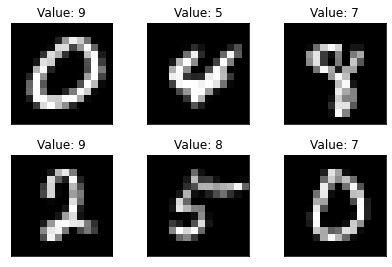

In [6]:
# displaying samples of data
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(test_input[i][0], cmap='gray')
  plt.title("Value: {}".format(train_classes[i][0]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

In [7]:
# plt.imshow(train_input[0][1],cmap='gray')
# plt.show()

In [8]:
print(train_input.shape)
print(train_input.dtype)
print(train_target.shape)
print(train_target.dtype)

torch.Size([1000, 2, 14, 14])
torch.float32
torch.Size([1000])
torch.int64


In [31]:
#weights_sharing_CNN
class CNN_Net_weight_sharing(nn.Module):
    def __init__(self):
        super(CNN_Net_weight_sharing, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64,128,kernel_size=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv2_drop=nn.Dropout2d()
        self.fc1 = nn.Linear(1024, 128)
#         self.fc2 = nn.Linear(128, 10)
        self.fc2 = nn.Linear(128,2)
#         self.fc3 = nn.Linear(10,2)
        #parameters
        self.batch_size = 50
        self.criterion = nn.CrossEntropyLoss()
        self.num_epochs = 25
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        
        img1 = x[:,0,:,:].view(-1,1,14,14)
        img2 = x[:,1,:,:].view(-1,1,14,14)
        
        img1 = F.relu(F.max_pool2d(self.conv1(img1), kernel_size=2, stride=2))
        img1 = F.relu(F.max_pool2d(self.conv2(img1), kernel_size=2, stride=2))
        img2 = F.relu(F.max_pool2d(self.conv1(img2), kernel_size=2, stride=2))
        img2 = F.relu(F.max_pool2d(self.conv2(img2), kernel_size=2, stride=2))
#         print(img1.shape)
        output = torch.cat((img1.view(-1, 512),img2.view(-1, 512)),1)
        output = F.relu(self.fc1(output))
#         output = F.relu(self.fc2(output))
        output = self.fc2(output)
        output = F.dropout(output,training=self.training)
        
        return output

        # Training Function

    def trainer(self, train_input, train_target):
        """
        Train the model on a training set
        :param train_input: Training features
        :param train_target: Training labels
        """
        loss_history=[]
        start_time = time.time()
        self.train()
        for epoch in range(self.num_epochs):
            for batch_idx in range(0,train_input.size(0),self.batch_size):
                output = self(train_input[batch_idx:batch_idx+self.batch_size])
                target = train_target[batch_idx:batch_idx+self.batch_size]
#                 print(output.shape)
#                 print(target.shape)
                loss = self.criterion(output, target)  
                self.optimizer.zero_grad()                          #清零梯度
                loss.backward()                                #反向求梯度
                self.optimizer.step()
#                 每隔50组数据，输出一次loss值
                if not batch_idx % 50:
                    print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.6f' 
                           %(epoch+1, self.num_epochs, batch_idx, 
                             len(train_input), loss))
                if batch_idx == 950:
                    loss_history.append(loss)
            print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
#       print the loss plot
        plt.plot(loss_history)
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.title("Loss plot")
        plt.show()

        # Test error

    def compute_error(self, input_data, target):
        """
        Compute the number of error of the model on a test set
        :param input_data: test features
        :param target: test target
        :return: error rate of the input data
        """  
    
        #测试模型
        self.eval()      #测试模式，关闭正则化
        errors = 0
        for idx in range(0,input_data.size(0),self.batch_size):
            input_batch=input_data.narrow(0,idx,self.batch_size)
            outputs = self(input_batch)
#             print(outputs)
            _, predicted = torch.max(outputs, 1)   #返回值和索引
            target_labels = target.narrow(0, idx, self.batch_size)
            errors += torch.sum(predicted != target_labels)

        return float(errors)*100/input_data.size(0)
    def save_model(self,model_name):
        """
        Save the model to a direction
        :param model_name: the model name, e.g. CNN_Net.pth
        """         
        torch.save(self, './model/'+ model_name)

In [32]:
my_model=CNN_Net_weight_sharing()
my_model.save_model('CNN_Net_weight_sharing.pth')

Epoch: 001/025 | Batch 000/1000 | Loss: 12.624417
Epoch: 001/025 | Batch 050/1000 | Loss: 32.907894
Epoch: 001/025 | Batch 100/1000 | Loss: 40.566185
Epoch: 001/025 | Batch 150/1000 | Loss: 15.077539
Epoch: 001/025 | Batch 200/1000 | Loss: 6.454383
Epoch: 001/025 | Batch 250/1000 | Loss: 4.443587
Epoch: 001/025 | Batch 300/1000 | Loss: 8.764381
Epoch: 001/025 | Batch 350/1000 | Loss: 6.934293
Epoch: 001/025 | Batch 400/1000 | Loss: 6.445123
Epoch: 001/025 | Batch 450/1000 | Loss: 3.606766
Epoch: 001/025 | Batch 500/1000 | Loss: 3.219234
Epoch: 001/025 | Batch 550/1000 | Loss: 2.034378
Epoch: 001/025 | Batch 600/1000 | Loss: 2.331779
Epoch: 001/025 | Batch 650/1000 | Loss: 3.264862
Epoch: 001/025 | Batch 700/1000 | Loss: 1.802741
Epoch: 001/025 | Batch 750/1000 | Loss: 0.799206
Epoch: 001/025 | Batch 800/1000 | Loss: 1.020829
Epoch: 001/025 | Batch 850/1000 | Loss: 0.949940
Epoch: 001/025 | Batch 900/1000 | Loss: 1.099188
Epoch: 001/025 | Batch 950/1000 | Loss: 0.903530
Time elapsed: 0.

Epoch: 009/025 | Batch 550/1000 | Loss: 0.582910
Epoch: 009/025 | Batch 600/1000 | Loss: 0.295071
Epoch: 009/025 | Batch 650/1000 | Loss: 0.397148
Epoch: 009/025 | Batch 700/1000 | Loss: 0.309934
Epoch: 009/025 | Batch 750/1000 | Loss: 0.296500
Epoch: 009/025 | Batch 800/1000 | Loss: 0.321628
Epoch: 009/025 | Batch 850/1000 | Loss: 0.312520
Epoch: 009/025 | Batch 900/1000 | Loss: 0.315900
Epoch: 009/025 | Batch 950/1000 | Loss: 0.331606
Time elapsed: 0.07 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.336072
Epoch: 010/025 | Batch 050/1000 | Loss: 0.265363
Epoch: 010/025 | Batch 100/1000 | Loss: 0.343345
Epoch: 010/025 | Batch 150/1000 | Loss: 0.319434
Epoch: 010/025 | Batch 200/1000 | Loss: 0.306158
Epoch: 010/025 | Batch 250/1000 | Loss: 0.315206
Epoch: 010/025 | Batch 300/1000 | Loss: 0.295152
Epoch: 010/025 | Batch 350/1000 | Loss: 0.248094
Epoch: 010/025 | Batch 400/1000 | Loss: 0.196006
Epoch: 010/025 | Batch 450/1000 | Loss: 0.339793
Epoch: 010/025 | Batch 500/1000 | Loss: 0.2837

Epoch: 017/025 | Batch 750/1000 | Loss: 0.162540
Epoch: 017/025 | Batch 800/1000 | Loss: 0.214029
Epoch: 017/025 | Batch 850/1000 | Loss: 0.166720
Epoch: 017/025 | Batch 900/1000 | Loss: 0.210037
Epoch: 017/025 | Batch 950/1000 | Loss: 0.297119
Time elapsed: 0.13 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.239459
Epoch: 018/025 | Batch 050/1000 | Loss: 0.095873
Epoch: 018/025 | Batch 100/1000 | Loss: 0.239599
Epoch: 018/025 | Batch 150/1000 | Loss: 0.176787
Epoch: 018/025 | Batch 200/1000 | Loss: 0.169715
Epoch: 018/025 | Batch 250/1000 | Loss: 0.211973
Epoch: 018/025 | Batch 300/1000 | Loss: 0.116994
Epoch: 018/025 | Batch 350/1000 | Loss: 0.128234
Epoch: 018/025 | Batch 400/1000 | Loss: 0.165329
Epoch: 018/025 | Batch 450/1000 | Loss: 0.172784
Epoch: 018/025 | Batch 500/1000 | Loss: 0.192787
Epoch: 018/025 | Batch 550/1000 | Loss: 0.282245
Epoch: 018/025 | Batch 600/1000 | Loss: 0.170010
Epoch: 018/025 | Batch 650/1000 | Loss: 0.150692
Epoch: 018/025 | Batch 700/1000 | Loss: 0.2061

Epoch: 025/025 | Batch 950/1000 | Loss: 0.270475
Time elapsed: 0.20 min
Total Training Time: 0.20 min


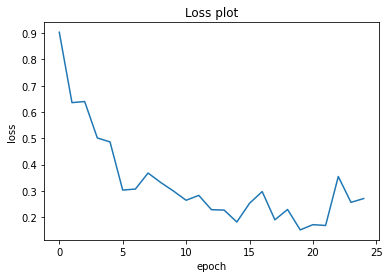

In [33]:
# train the model
my_model.trainer(train_input, train_target)

In [34]:
# output the train error and test error
print("Train error : %.1f%% \nTest error : %.1f%%" %
      (my_model.compute_error(train_input, train_target),
       my_model.compute_error(test_input, test_target)))

print("The total number of the parameters is: %d" % (sum(p.numel() for p in my_model.parameters())))

tensor([[-2.5315,  2.9145],
        [-1.0420,  1.2607],
        [-2.3876,  2.6366],
        [ 3.8715, -3.7317],
        [ 5.5910, -5.1724],
        [ 1.8778, -2.5027],
        [ 5.3758, -5.0205],
        [-3.3712,  3.7711],
        [ 2.7172, -2.5370],
        [-2.8060,  3.1960],
        [-9.0021, 10.3983],
        [ 2.2587, -0.9420],
        [-4.5005,  3.8142],
        [ 2.0721, -2.0612],
        [-2.2181,  1.7773],
        [ 3.8515, -3.3662],
        [ 1.1646, -0.8138],
        [-3.3412,  3.4078],
        [-1.8968,  2.0024],
        [-0.0834,  0.0158],
        [ 0.8282, -0.0932],
        [ 4.1765, -4.0059],
        [ 2.2468, -1.5962],
        [-0.8442,  0.7367],
        [-4.8747,  5.5537],
        [-4.0750,  4.2417],
        [-5.8473,  6.1809],
        [-1.1290,  1.6342],
        [-2.2445,  2.7560],
        [-2.9133,  3.6050],
        [-0.9488,  0.2948],
        [ 4.5231, -4.1065],
        [ 0.9096, -0.0604],
        [-4.0607,  4.1862],
        [-3.4208,  3.0219],
        [ 3.9041, -4

tensor([[ -3.9747,   4.4929],
        [  2.0191,  -1.8954],
        [ -8.1003,   9.2873],
        [  4.4994,  -4.7257],
        [  2.8189,  -2.0222],
        [  1.4083,  -1.3753],
        [ -5.3784,   4.8646],
        [ -2.5507,   2.3587],
        [ -4.1326,   3.4048],
        [  1.2056,  -1.1681],
        [ -2.8860,   2.9140],
        [  4.7942,  -3.5819],
        [ -6.2667,   7.4884],
        [ -2.7584,   3.3429],
        [ -0.6284,   0.5939],
        [  1.4988,  -0.4933],
        [  0.1146,   0.3689],
        [ -2.2470,   2.1098],
        [  4.7405,  -4.5111],
        [  2.6263,  -3.2726],
        [  2.9496,  -3.0982],
        [ -3.0250,   2.7435],
        [ -0.0942,   0.0508],
        [  4.3191,  -3.4641],
        [  4.3764,  -3.5542],
        [  1.7471,  -1.7581],
        [  0.8642,  -0.5923],
        [ -4.2960,   3.9858],
        [  1.5689,  -1.7957],
        [  1.5561,  -1.7744],
        [ -6.9007,   6.7517],
        [  1.0188,  -0.3859],
        [ -2.4317,   3.3803],
        [ 

tensor([[ -2.1139,   2.6157],
        [  5.5337,  -5.2957],
        [  1.8089,  -1.4542],
        [ -4.2046,   4.8585],
        [ -3.4279,   3.7861],
        [ -2.5922,   2.9000],
        [-11.7323,  13.0379],
        [ -4.6649,   4.4192],
        [ -2.9277,   3.2699],
        [  4.6945,  -4.3783],
        [ -1.8649,   2.7427],
        [ -6.6372,   7.4151],
        [ -5.7074,   6.4357],
        [  4.0245,  -3.1386],
        [ -0.3048,   0.9265],
        [  3.6815,  -3.4238],
        [ -0.7652,   0.8414],
        [  1.4728,  -0.6428],
        [ -5.2086,   6.2710],
        [ -9.2883,   9.9123],
        [ -4.2398,   4.8681],
        [  4.3648,  -4.2595],
        [ -2.0037,   1.7500],
        [  2.6613,  -2.2252],
        [ -3.1338,   2.9131],
        [  2.9212,  -2.4814],
        [ -1.4116,   1.6352],
        [  2.6809,  -1.9886],
        [ -2.4002,   2.6078],
        [ -7.0133,   7.2720],
        [  4.7167,  -4.2584],
        [ -6.4976,   6.1442],
        [  0.8297,  -0.2597],
        [ 

Epoch: 001/025 | Batch 000/1000 | Loss: 10.359859
Epoch: 001/025 | Batch 050/1000 | Loss: 37.563576
Epoch: 001/025 | Batch 100/1000 | Loss: 36.283279
Epoch: 001/025 | Batch 150/1000 | Loss: 12.755823
Epoch: 001/025 | Batch 200/1000 | Loss: 3.819549
Epoch: 001/025 | Batch 250/1000 | Loss: 6.244016
Epoch: 001/025 | Batch 300/1000 | Loss: 5.529948
Epoch: 001/025 | Batch 350/1000 | Loss: 3.196691
Epoch: 001/025 | Batch 400/1000 | Loss: 7.461483
Epoch: 001/025 | Batch 450/1000 | Loss: 5.287698
Epoch: 001/025 | Batch 500/1000 | Loss: 1.502704
Epoch: 001/025 | Batch 550/1000 | Loss: 0.713163
Epoch: 001/025 | Batch 600/1000 | Loss: 0.934796
Epoch: 001/025 | Batch 650/1000 | Loss: 1.250064
Epoch: 001/025 | Batch 700/1000 | Loss: 0.882175
Epoch: 001/025 | Batch 750/1000 | Loss: 1.187453
Epoch: 001/025 | Batch 800/1000 | Loss: 1.057440
Epoch: 001/025 | Batch 850/1000 | Loss: 1.011534
Epoch: 001/025 | Batch 900/1000 | Loss: 0.920858
Epoch: 001/025 | Batch 950/1000 | Loss: 0.727362
Time elapsed: 0.

Epoch: 009/025 | Batch 450/1000 | Loss: 0.447885
Epoch: 009/025 | Batch 500/1000 | Loss: 0.312787
Epoch: 009/025 | Batch 550/1000 | Loss: 0.291400
Epoch: 009/025 | Batch 600/1000 | Loss: 0.217188
Epoch: 009/025 | Batch 650/1000 | Loss: 0.356666
Epoch: 009/025 | Batch 700/1000 | Loss: 0.373861
Epoch: 009/025 | Batch 750/1000 | Loss: 0.347869
Epoch: 009/025 | Batch 800/1000 | Loss: 0.352715
Epoch: 009/025 | Batch 850/1000 | Loss: 0.447042
Epoch: 009/025 | Batch 900/1000 | Loss: 0.396798
Epoch: 009/025 | Batch 950/1000 | Loss: 0.311393
Time elapsed: 0.07 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.422543
Epoch: 010/025 | Batch 050/1000 | Loss: 0.337813
Epoch: 010/025 | Batch 100/1000 | Loss: 0.392231
Epoch: 010/025 | Batch 150/1000 | Loss: 0.216743
Epoch: 010/025 | Batch 200/1000 | Loss: 0.429330
Epoch: 010/025 | Batch 250/1000 | Loss: 0.413772
Epoch: 010/025 | Batch 300/1000 | Loss: 0.356328
Epoch: 010/025 | Batch 350/1000 | Loss: 0.371982
Epoch: 010/025 | Batch 400/1000 | Loss: 0.2778

Epoch: 017/025 | Batch 950/1000 | Loss: 0.184268
Time elapsed: 0.14 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.232152
Epoch: 018/025 | Batch 050/1000 | Loss: 0.165603
Epoch: 018/025 | Batch 100/1000 | Loss: 0.211492
Epoch: 018/025 | Batch 150/1000 | Loss: 0.206013
Epoch: 018/025 | Batch 200/1000 | Loss: 0.239093
Epoch: 018/025 | Batch 250/1000 | Loss: 0.241926
Epoch: 018/025 | Batch 300/1000 | Loss: 0.233722
Epoch: 018/025 | Batch 350/1000 | Loss: 0.257982
Epoch: 018/025 | Batch 400/1000 | Loss: 0.294759
Epoch: 018/025 | Batch 450/1000 | Loss: 0.321114
Epoch: 018/025 | Batch 500/1000 | Loss: 0.235521
Epoch: 018/025 | Batch 550/1000 | Loss: 0.178702
Epoch: 018/025 | Batch 600/1000 | Loss: 0.266069
Epoch: 018/025 | Batch 650/1000 | Loss: 0.281416
Epoch: 018/025 | Batch 700/1000 | Loss: 0.281755
Epoch: 018/025 | Batch 750/1000 | Loss: 0.227878
Epoch: 018/025 | Batch 800/1000 | Loss: 0.243154
Epoch: 018/025 | Batch 850/1000 | Loss: 0.186395
Epoch: 018/025 | Batch 900/1000 | Loss: 0.1799

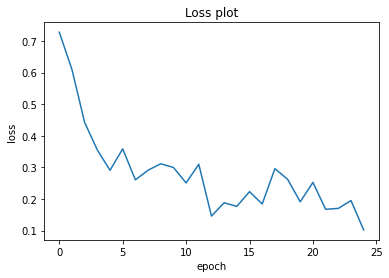

Epoch: 001/025 | Batch 000/1000 | Loss: 2.431209
Epoch: 001/025 | Batch 050/1000 | Loss: 16.458942
Epoch: 001/025 | Batch 100/1000 | Loss: 45.951420
Epoch: 001/025 | Batch 150/1000 | Loss: 15.317021
Epoch: 001/025 | Batch 200/1000 | Loss: 1.919363
Epoch: 001/025 | Batch 250/1000 | Loss: 8.132190
Epoch: 001/025 | Batch 300/1000 | Loss: 8.549264
Epoch: 001/025 | Batch 350/1000 | Loss: 3.988862
Epoch: 001/025 | Batch 400/1000 | Loss: 2.832439
Epoch: 001/025 | Batch 450/1000 | Loss: 1.783113
Epoch: 001/025 | Batch 500/1000 | Loss: 2.205348
Epoch: 001/025 | Batch 550/1000 | Loss: 1.924756
Epoch: 001/025 | Batch 600/1000 | Loss: 1.977728
Epoch: 001/025 | Batch 650/1000 | Loss: 1.132745
Epoch: 001/025 | Batch 700/1000 | Loss: 1.089771
Epoch: 001/025 | Batch 750/1000 | Loss: 1.142587
Epoch: 001/025 | Batch 800/1000 | Loss: 0.937015
Epoch: 001/025 | Batch 850/1000 | Loss: 1.021155
Epoch: 001/025 | Batch 900/1000 | Loss: 1.021567
Epoch: 001/025 | Batch 950/1000 | Loss: 0.961464
Time elapsed: 0.0

Epoch: 009/025 | Batch 400/1000 | Loss: 0.360539
Epoch: 009/025 | Batch 450/1000 | Loss: 0.321065
Epoch: 009/025 | Batch 500/1000 | Loss: 0.356846
Epoch: 009/025 | Batch 550/1000 | Loss: 0.282055
Epoch: 009/025 | Batch 600/1000 | Loss: 0.423874
Epoch: 009/025 | Batch 650/1000 | Loss: 0.329061
Epoch: 009/025 | Batch 700/1000 | Loss: 0.415857
Epoch: 009/025 | Batch 750/1000 | Loss: 0.319140
Epoch: 009/025 | Batch 800/1000 | Loss: 0.275587
Epoch: 009/025 | Batch 850/1000 | Loss: 0.352422
Epoch: 009/025 | Batch 900/1000 | Loss: 0.303310
Epoch: 009/025 | Batch 950/1000 | Loss: 0.440627
Time elapsed: 0.08 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.360200
Epoch: 010/025 | Batch 050/1000 | Loss: 0.345475
Epoch: 010/025 | Batch 100/1000 | Loss: 0.369017
Epoch: 010/025 | Batch 150/1000 | Loss: 0.293126
Epoch: 010/025 | Batch 200/1000 | Loss: 0.369074
Epoch: 010/025 | Batch 250/1000 | Loss: 0.426608
Epoch: 010/025 | Batch 300/1000 | Loss: 0.354813
Epoch: 010/025 | Batch 350/1000 | Loss: 0.3180

Epoch: 017/025 | Batch 750/1000 | Loss: 0.240918
Epoch: 017/025 | Batch 800/1000 | Loss: 0.224890
Epoch: 017/025 | Batch 850/1000 | Loss: 0.245680
Epoch: 017/025 | Batch 900/1000 | Loss: 0.296907
Epoch: 017/025 | Batch 950/1000 | Loss: 0.317265
Time elapsed: 0.15 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.230213
Epoch: 018/025 | Batch 050/1000 | Loss: 0.148817
Epoch: 018/025 | Batch 100/1000 | Loss: 0.218956
Epoch: 018/025 | Batch 150/1000 | Loss: 0.216589
Epoch: 018/025 | Batch 200/1000 | Loss: 0.298756
Epoch: 018/025 | Batch 250/1000 | Loss: 0.345250
Epoch: 018/025 | Batch 300/1000 | Loss: 0.252643
Epoch: 018/025 | Batch 350/1000 | Loss: 0.183964
Epoch: 018/025 | Batch 400/1000 | Loss: 0.197561
Epoch: 018/025 | Batch 450/1000 | Loss: 0.258919
Epoch: 018/025 | Batch 500/1000 | Loss: 0.280303
Epoch: 018/025 | Batch 550/1000 | Loss: 0.206718
Epoch: 018/025 | Batch 600/1000 | Loss: 0.214616
Epoch: 018/025 | Batch 650/1000 | Loss: 0.149551
Epoch: 018/025 | Batch 700/1000 | Loss: 0.1564

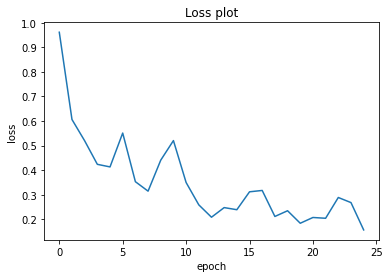

Epoch: 001/025 | Batch 000/1000 | Loss: 30.279961
Epoch: 001/025 | Batch 050/1000 | Loss: 36.216000
Epoch: 001/025 | Batch 100/1000 | Loss: 18.833326
Epoch: 001/025 | Batch 150/1000 | Loss: 30.304550
Epoch: 001/025 | Batch 200/1000 | Loss: 10.046360
Epoch: 001/025 | Batch 250/1000 | Loss: 4.065917
Epoch: 001/025 | Batch 300/1000 | Loss: 5.356261
Epoch: 001/025 | Batch 350/1000 | Loss: 5.794948
Epoch: 001/025 | Batch 400/1000 | Loss: 4.991267
Epoch: 001/025 | Batch 450/1000 | Loss: 2.864533
Epoch: 001/025 | Batch 500/1000 | Loss: 1.286750
Epoch: 001/025 | Batch 550/1000 | Loss: 1.273482
Epoch: 001/025 | Batch 600/1000 | Loss: 1.583359
Epoch: 001/025 | Batch 650/1000 | Loss: 4.094177
Epoch: 001/025 | Batch 700/1000 | Loss: 3.338893
Epoch: 001/025 | Batch 750/1000 | Loss: 2.415164
Epoch: 001/025 | Batch 800/1000 | Loss: 2.637809
Epoch: 001/025 | Batch 850/1000 | Loss: 0.911345
Epoch: 001/025 | Batch 900/1000 | Loss: 0.679004
Epoch: 001/025 | Batch 950/1000 | Loss: 1.608622
Time elapsed: 0

Epoch: 009/025 | Batch 350/1000 | Loss: 0.429998
Epoch: 009/025 | Batch 400/1000 | Loss: 0.289898
Epoch: 009/025 | Batch 450/1000 | Loss: 0.475660
Epoch: 009/025 | Batch 500/1000 | Loss: 0.367324
Epoch: 009/025 | Batch 550/1000 | Loss: 0.434805
Epoch: 009/025 | Batch 600/1000 | Loss: 0.294559
Epoch: 009/025 | Batch 650/1000 | Loss: 0.364947
Epoch: 009/025 | Batch 700/1000 | Loss: 0.311545
Epoch: 009/025 | Batch 750/1000 | Loss: 0.571249
Epoch: 009/025 | Batch 800/1000 | Loss: 0.380048
Epoch: 009/025 | Batch 850/1000 | Loss: 0.298413
Epoch: 009/025 | Batch 900/1000 | Loss: 0.325552
Epoch: 009/025 | Batch 950/1000 | Loss: 0.447437
Time elapsed: 0.08 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.358103
Epoch: 010/025 | Batch 050/1000 | Loss: 0.297844
Epoch: 010/025 | Batch 100/1000 | Loss: 0.465429
Epoch: 010/025 | Batch 150/1000 | Loss: 0.335081
Epoch: 010/025 | Batch 200/1000 | Loss: 0.420569
Epoch: 010/025 | Batch 250/1000 | Loss: 0.348707
Epoch: 010/025 | Batch 300/1000 | Loss: 0.4992

Epoch: 017/025 | Batch 900/1000 | Loss: 0.265728
Epoch: 017/025 | Batch 950/1000 | Loss: 0.169796
Time elapsed: 0.16 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.209167
Epoch: 018/025 | Batch 050/1000 | Loss: 0.177183
Epoch: 018/025 | Batch 100/1000 | Loss: 0.232734
Epoch: 018/025 | Batch 150/1000 | Loss: 0.204123
Epoch: 018/025 | Batch 200/1000 | Loss: 0.266792
Epoch: 018/025 | Batch 250/1000 | Loss: 0.195247
Epoch: 018/025 | Batch 300/1000 | Loss: 0.157996
Epoch: 018/025 | Batch 350/1000 | Loss: 0.330177
Epoch: 018/025 | Batch 400/1000 | Loss: 0.156543
Epoch: 018/025 | Batch 450/1000 | Loss: 0.251813
Epoch: 018/025 | Batch 500/1000 | Loss: 0.222284
Epoch: 018/025 | Batch 550/1000 | Loss: 0.269287
Epoch: 018/025 | Batch 600/1000 | Loss: 0.136532
Epoch: 018/025 | Batch 650/1000 | Loss: 0.170596
Epoch: 018/025 | Batch 700/1000 | Loss: 0.245791
Epoch: 018/025 | Batch 750/1000 | Loss: 0.205826
Epoch: 018/025 | Batch 800/1000 | Loss: 0.200665
Epoch: 018/025 | Batch 850/1000 | Loss: 0.2164

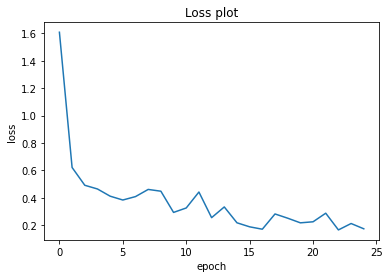

Epoch: 001/025 | Batch 000/1000 | Loss: 11.487075
Epoch: 001/025 | Batch 050/1000 | Loss: 21.649229
Epoch: 001/025 | Batch 100/1000 | Loss: 17.988663
Epoch: 001/025 | Batch 150/1000 | Loss: 14.471111
Epoch: 001/025 | Batch 200/1000 | Loss: 4.294334
Epoch: 001/025 | Batch 250/1000 | Loss: 5.860099
Epoch: 001/025 | Batch 300/1000 | Loss: 4.834556
Epoch: 001/025 | Batch 350/1000 | Loss: 9.628500
Epoch: 001/025 | Batch 400/1000 | Loss: 6.022232
Epoch: 001/025 | Batch 450/1000 | Loss: 3.600745
Epoch: 001/025 | Batch 500/1000 | Loss: 2.559528
Epoch: 001/025 | Batch 550/1000 | Loss: 1.789256
Epoch: 001/025 | Batch 600/1000 | Loss: 0.894206
Epoch: 001/025 | Batch 650/1000 | Loss: 1.087408
Epoch: 001/025 | Batch 700/1000 | Loss: 1.559227
Epoch: 001/025 | Batch 750/1000 | Loss: 1.041159
Epoch: 001/025 | Batch 800/1000 | Loss: 0.881585
Epoch: 001/025 | Batch 850/1000 | Loss: 0.709401
Epoch: 001/025 | Batch 900/1000 | Loss: 0.695832
Epoch: 001/025 | Batch 950/1000 | Loss: 0.568030
Time elapsed: 0.

Epoch: 009/025 | Batch 300/1000 | Loss: 0.316721
Epoch: 009/025 | Batch 350/1000 | Loss: 0.354153
Epoch: 009/025 | Batch 400/1000 | Loss: 0.311960
Epoch: 009/025 | Batch 450/1000 | Loss: 0.287865
Epoch: 009/025 | Batch 500/1000 | Loss: 0.356065
Epoch: 009/025 | Batch 550/1000 | Loss: 0.362155
Epoch: 009/025 | Batch 600/1000 | Loss: 0.283303
Epoch: 009/025 | Batch 650/1000 | Loss: 0.294105
Epoch: 009/025 | Batch 700/1000 | Loss: 0.352504
Epoch: 009/025 | Batch 750/1000 | Loss: 0.308397
Epoch: 009/025 | Batch 800/1000 | Loss: 0.286446
Epoch: 009/025 | Batch 850/1000 | Loss: 0.354565
Epoch: 009/025 | Batch 900/1000 | Loss: 0.310827
Epoch: 009/025 | Batch 950/1000 | Loss: 0.296269
Time elapsed: 0.08 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.356102
Epoch: 010/025 | Batch 050/1000 | Loss: 0.365266
Epoch: 010/025 | Batch 100/1000 | Loss: 0.379416
Epoch: 010/025 | Batch 150/1000 | Loss: 0.367082
Epoch: 010/025 | Batch 200/1000 | Loss: 0.269771
Epoch: 010/025 | Batch 250/1000 | Loss: 0.3201

Epoch: 017/025 | Batch 550/1000 | Loss: 0.222337
Epoch: 017/025 | Batch 600/1000 | Loss: 0.209767
Epoch: 017/025 | Batch 650/1000 | Loss: 0.239900
Epoch: 017/025 | Batch 700/1000 | Loss: 0.165374
Epoch: 017/025 | Batch 750/1000 | Loss: 0.223803
Epoch: 017/025 | Batch 800/1000 | Loss: 0.279720
Epoch: 017/025 | Batch 850/1000 | Loss: 0.206198
Epoch: 017/025 | Batch 900/1000 | Loss: 0.248102
Epoch: 017/025 | Batch 950/1000 | Loss: 0.275123
Time elapsed: 0.16 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.237880
Epoch: 018/025 | Batch 050/1000 | Loss: 0.207086
Epoch: 018/025 | Batch 100/1000 | Loss: 0.270443
Epoch: 018/025 | Batch 150/1000 | Loss: 0.188782
Epoch: 018/025 | Batch 200/1000 | Loss: 0.300499
Epoch: 018/025 | Batch 250/1000 | Loss: 0.202060
Epoch: 018/025 | Batch 300/1000 | Loss: 0.289036
Epoch: 018/025 | Batch 350/1000 | Loss: 0.278760
Epoch: 018/025 | Batch 400/1000 | Loss: 0.223957
Epoch: 018/025 | Batch 450/1000 | Loss: 0.258545
Epoch: 018/025 | Batch 500/1000 | Loss: 0.1965

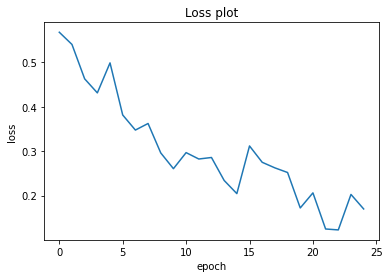

Epoch: 001/025 | Batch 000/1000 | Loss: 4.159531
Epoch: 001/025 | Batch 050/1000 | Loss: 39.951488
Epoch: 001/025 | Batch 100/1000 | Loss: 30.822779
Epoch: 001/025 | Batch 150/1000 | Loss: 10.164081
Epoch: 001/025 | Batch 200/1000 | Loss: 12.460265
Epoch: 001/025 | Batch 250/1000 | Loss: 7.622973
Epoch: 001/025 | Batch 300/1000 | Loss: 4.084024
Epoch: 001/025 | Batch 350/1000 | Loss: 1.688877
Epoch: 001/025 | Batch 400/1000 | Loss: 5.631248
Epoch: 001/025 | Batch 450/1000 | Loss: 7.573951
Epoch: 001/025 | Batch 500/1000 | Loss: 5.880069
Epoch: 001/025 | Batch 550/1000 | Loss: 2.407020
Epoch: 001/025 | Batch 600/1000 | Loss: 1.537732
Epoch: 001/025 | Batch 650/1000 | Loss: 1.234955
Epoch: 001/025 | Batch 700/1000 | Loss: 1.838869
Epoch: 001/025 | Batch 750/1000 | Loss: 1.717846
Epoch: 001/025 | Batch 800/1000 | Loss: 0.962070
Epoch: 001/025 | Batch 850/1000 | Loss: 1.224631
Epoch: 001/025 | Batch 900/1000 | Loss: 0.683907
Epoch: 001/025 | Batch 950/1000 | Loss: 0.689936
Time elapsed: 0.

Epoch: 009/025 | Batch 300/1000 | Loss: 0.284245
Epoch: 009/025 | Batch 350/1000 | Loss: 0.290883
Epoch: 009/025 | Batch 400/1000 | Loss: 0.299167
Epoch: 009/025 | Batch 450/1000 | Loss: 0.332658
Epoch: 009/025 | Batch 500/1000 | Loss: 0.282531
Epoch: 009/025 | Batch 550/1000 | Loss: 0.225390
Epoch: 009/025 | Batch 600/1000 | Loss: 0.370942
Epoch: 009/025 | Batch 650/1000 | Loss: 0.352117
Epoch: 009/025 | Batch 700/1000 | Loss: 0.338939
Epoch: 009/025 | Batch 750/1000 | Loss: 0.285471
Epoch: 009/025 | Batch 800/1000 | Loss: 0.335660
Epoch: 009/025 | Batch 850/1000 | Loss: 0.258879
Epoch: 009/025 | Batch 900/1000 | Loss: 0.313616
Epoch: 009/025 | Batch 950/1000 | Loss: 0.363845
Time elapsed: 0.08 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.392743
Epoch: 010/025 | Batch 050/1000 | Loss: 0.408201
Epoch: 010/025 | Batch 100/1000 | Loss: 0.272510
Epoch: 010/025 | Batch 150/1000 | Loss: 0.427490
Epoch: 010/025 | Batch 200/1000 | Loss: 0.431085
Epoch: 010/025 | Batch 250/1000 | Loss: 0.2923

Epoch: 017/025 | Batch 650/1000 | Loss: 0.157070
Epoch: 017/025 | Batch 700/1000 | Loss: 0.178543
Epoch: 017/025 | Batch 750/1000 | Loss: 0.246561
Epoch: 017/025 | Batch 800/1000 | Loss: 0.205451
Epoch: 017/025 | Batch 850/1000 | Loss: 0.156015
Epoch: 017/025 | Batch 900/1000 | Loss: 0.157182
Epoch: 017/025 | Batch 950/1000 | Loss: 0.280600
Time elapsed: 0.15 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.181252
Epoch: 018/025 | Batch 050/1000 | Loss: 0.106096
Epoch: 018/025 | Batch 100/1000 | Loss: 0.203124
Epoch: 018/025 | Batch 150/1000 | Loss: 0.175343
Epoch: 018/025 | Batch 200/1000 | Loss: 0.257774
Epoch: 018/025 | Batch 250/1000 | Loss: 0.190822
Epoch: 018/025 | Batch 300/1000 | Loss: 0.284402
Epoch: 018/025 | Batch 350/1000 | Loss: 0.115296
Epoch: 018/025 | Batch 400/1000 | Loss: 0.173303
Epoch: 018/025 | Batch 450/1000 | Loss: 0.182740
Epoch: 018/025 | Batch 500/1000 | Loss: 0.178086
Epoch: 018/025 | Batch 550/1000 | Loss: 0.215422
Epoch: 018/025 | Batch 600/1000 | Loss: 0.1297

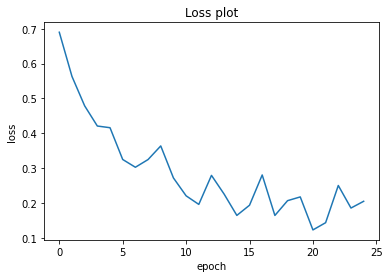

Epoch: 001/025 | Batch 000/1000 | Loss: 6.701996
Epoch: 001/025 | Batch 050/1000 | Loss: 45.832970
Epoch: 001/025 | Batch 100/1000 | Loss: 29.167425
Epoch: 001/025 | Batch 150/1000 | Loss: 10.480884
Epoch: 001/025 | Batch 200/1000 | Loss: 10.397760
Epoch: 001/025 | Batch 250/1000 | Loss: 9.174182
Epoch: 001/025 | Batch 300/1000 | Loss: 4.595125
Epoch: 001/025 | Batch 350/1000 | Loss: 3.656111
Epoch: 001/025 | Batch 400/1000 | Loss: 2.848336
Epoch: 001/025 | Batch 450/1000 | Loss: 4.304451
Epoch: 001/025 | Batch 500/1000 | Loss: 1.911801
Epoch: 001/025 | Batch 550/1000 | Loss: 0.757960
Epoch: 001/025 | Batch 600/1000 | Loss: 1.016021
Epoch: 001/025 | Batch 650/1000 | Loss: 1.541771
Epoch: 001/025 | Batch 700/1000 | Loss: 1.209926
Epoch: 001/025 | Batch 750/1000 | Loss: 0.738477
Epoch: 001/025 | Batch 800/1000 | Loss: 0.704981
Epoch: 001/025 | Batch 850/1000 | Loss: 0.932808
Epoch: 001/025 | Batch 900/1000 | Loss: 0.666118
Epoch: 001/025 | Batch 950/1000 | Loss: 0.784004
Time elapsed: 0.

Epoch: 009/025 | Batch 400/1000 | Loss: 0.352156
Epoch: 009/025 | Batch 450/1000 | Loss: 0.346059
Epoch: 009/025 | Batch 500/1000 | Loss: 0.280516
Epoch: 009/025 | Batch 550/1000 | Loss: 0.414492
Epoch: 009/025 | Batch 600/1000 | Loss: 0.323119
Epoch: 009/025 | Batch 650/1000 | Loss: 0.316590
Epoch: 009/025 | Batch 700/1000 | Loss: 0.269848
Epoch: 009/025 | Batch 750/1000 | Loss: 0.298055
Epoch: 009/025 | Batch 800/1000 | Loss: 0.383788
Epoch: 009/025 | Batch 850/1000 | Loss: 0.417390
Epoch: 009/025 | Batch 900/1000 | Loss: 0.227889
Epoch: 009/025 | Batch 950/1000 | Loss: 0.495471
Time elapsed: 0.10 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.338100
Epoch: 010/025 | Batch 050/1000 | Loss: 0.228163
Epoch: 010/025 | Batch 100/1000 | Loss: 0.305223
Epoch: 010/025 | Batch 150/1000 | Loss: 0.488287
Epoch: 010/025 | Batch 200/1000 | Loss: 0.354544
Epoch: 010/025 | Batch 250/1000 | Loss: 0.343239
Epoch: 010/025 | Batch 300/1000 | Loss: 0.325074
Epoch: 010/025 | Batch 350/1000 | Loss: 0.3328

Epoch: 017/025 | Batch 850/1000 | Loss: 0.299499
Epoch: 017/025 | Batch 900/1000 | Loss: 0.284577
Epoch: 017/025 | Batch 950/1000 | Loss: 0.194756
Time elapsed: 0.20 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.238722
Epoch: 018/025 | Batch 050/1000 | Loss: 0.233997
Epoch: 018/025 | Batch 100/1000 | Loss: 0.202870
Epoch: 018/025 | Batch 150/1000 | Loss: 0.271621
Epoch: 018/025 | Batch 200/1000 | Loss: 0.299466
Epoch: 018/025 | Batch 250/1000 | Loss: 0.254834
Epoch: 018/025 | Batch 300/1000 | Loss: 0.255359
Epoch: 018/025 | Batch 350/1000 | Loss: 0.184487
Epoch: 018/025 | Batch 400/1000 | Loss: 0.211708
Epoch: 018/025 | Batch 450/1000 | Loss: 0.220884
Epoch: 018/025 | Batch 500/1000 | Loss: 0.198421
Epoch: 018/025 | Batch 550/1000 | Loss: 0.200734
Epoch: 018/025 | Batch 600/1000 | Loss: 0.309069
Epoch: 018/025 | Batch 650/1000 | Loss: 0.195292
Epoch: 018/025 | Batch 700/1000 | Loss: 0.217736
Epoch: 018/025 | Batch 750/1000 | Loss: 0.238168
Epoch: 018/025 | Batch 800/1000 | Loss: 0.1644

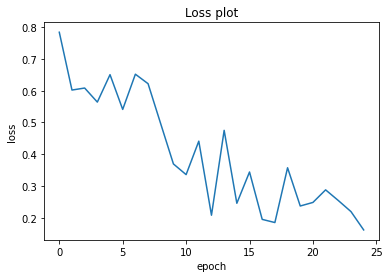

Epoch: 001/025 | Batch 000/1000 | Loss: 6.712077
Epoch: 001/025 | Batch 050/1000 | Loss: 45.992382
Epoch: 001/025 | Batch 100/1000 | Loss: 15.968171
Epoch: 001/025 | Batch 150/1000 | Loss: 7.302673
Epoch: 001/025 | Batch 200/1000 | Loss: 7.774281
Epoch: 001/025 | Batch 250/1000 | Loss: 5.065079
Epoch: 001/025 | Batch 300/1000 | Loss: 2.890760
Epoch: 001/025 | Batch 350/1000 | Loss: 2.598449
Epoch: 001/025 | Batch 400/1000 | Loss: 3.177229
Epoch: 001/025 | Batch 450/1000 | Loss: 3.171061
Epoch: 001/025 | Batch 500/1000 | Loss: 1.744645
Epoch: 001/025 | Batch 550/1000 | Loss: 1.141762
Epoch: 001/025 | Batch 600/1000 | Loss: 0.845059
Epoch: 001/025 | Batch 650/1000 | Loss: 0.847916
Epoch: 001/025 | Batch 700/1000 | Loss: 1.060021
Epoch: 001/025 | Batch 750/1000 | Loss: 1.078712
Epoch: 001/025 | Batch 800/1000 | Loss: 1.215951
Epoch: 001/025 | Batch 850/1000 | Loss: 0.930570
Epoch: 001/025 | Batch 900/1000 | Loss: 0.861028
Epoch: 001/025 | Batch 950/1000 | Loss: 0.838676
Time elapsed: 0.01

Epoch: 009/025 | Batch 350/1000 | Loss: 0.284632
Epoch: 009/025 | Batch 400/1000 | Loss: 0.354228
Epoch: 009/025 | Batch 450/1000 | Loss: 0.356896
Epoch: 009/025 | Batch 500/1000 | Loss: 0.403793
Epoch: 009/025 | Batch 550/1000 | Loss: 0.412826
Epoch: 009/025 | Batch 600/1000 | Loss: 0.325677
Epoch: 009/025 | Batch 650/1000 | Loss: 0.312328
Epoch: 009/025 | Batch 700/1000 | Loss: 0.311513
Epoch: 009/025 | Batch 750/1000 | Loss: 0.360145
Epoch: 009/025 | Batch 800/1000 | Loss: 0.319633
Epoch: 009/025 | Batch 850/1000 | Loss: 0.315678
Epoch: 009/025 | Batch 900/1000 | Loss: 0.397793
Epoch: 009/025 | Batch 950/1000 | Loss: 0.410039
Time elapsed: 0.13 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.320423
Epoch: 010/025 | Batch 050/1000 | Loss: 0.335677
Epoch: 010/025 | Batch 100/1000 | Loss: 0.390513
Epoch: 010/025 | Batch 150/1000 | Loss: 0.334135
Epoch: 010/025 | Batch 200/1000 | Loss: 0.464831
Epoch: 010/025 | Batch 250/1000 | Loss: 0.340273
Epoch: 010/025 | Batch 300/1000 | Loss: 0.3538

Epoch: 017/025 | Batch 800/1000 | Loss: 0.254759
Epoch: 017/025 | Batch 850/1000 | Loss: 0.204740
Epoch: 017/025 | Batch 900/1000 | Loss: 0.270147
Epoch: 017/025 | Batch 950/1000 | Loss: 0.186790
Time elapsed: 0.22 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.338940
Epoch: 018/025 | Batch 050/1000 | Loss: 0.273409
Epoch: 018/025 | Batch 100/1000 | Loss: 0.455596
Epoch: 018/025 | Batch 150/1000 | Loss: 0.169285
Epoch: 018/025 | Batch 200/1000 | Loss: 0.211741
Epoch: 018/025 | Batch 250/1000 | Loss: 0.166821
Epoch: 018/025 | Batch 300/1000 | Loss: 0.259889
Epoch: 018/025 | Batch 350/1000 | Loss: 0.207216
Epoch: 018/025 | Batch 400/1000 | Loss: 0.199209
Epoch: 018/025 | Batch 450/1000 | Loss: 0.170756
Epoch: 018/025 | Batch 500/1000 | Loss: 0.220079
Epoch: 018/025 | Batch 550/1000 | Loss: 0.204316
Epoch: 018/025 | Batch 600/1000 | Loss: 0.266217
Epoch: 018/025 | Batch 650/1000 | Loss: 0.291536
Epoch: 018/025 | Batch 700/1000 | Loss: 0.266818
Epoch: 018/025 | Batch 750/1000 | Loss: 0.2246

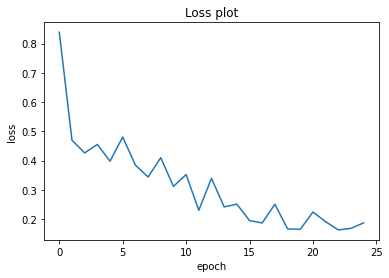

Epoch: 001/025 | Batch 000/1000 | Loss: 5.200295
Epoch: 001/025 | Batch 050/1000 | Loss: 65.575089
Epoch: 001/025 | Batch 100/1000 | Loss: 21.708324
Epoch: 001/025 | Batch 150/1000 | Loss: 7.867440
Epoch: 001/025 | Batch 200/1000 | Loss: 6.065417
Epoch: 001/025 | Batch 250/1000 | Loss: 6.453524
Epoch: 001/025 | Batch 300/1000 | Loss: 10.823761
Epoch: 001/025 | Batch 350/1000 | Loss: 8.248981
Epoch: 001/025 | Batch 400/1000 | Loss: 4.197506
Epoch: 001/025 | Batch 450/1000 | Loss: 1.564162
Epoch: 001/025 | Batch 500/1000 | Loss: 2.765646
Epoch: 001/025 | Batch 550/1000 | Loss: 4.076589
Epoch: 001/025 | Batch 600/1000 | Loss: 5.377132
Epoch: 001/025 | Batch 650/1000 | Loss: 3.364061
Epoch: 001/025 | Batch 700/1000 | Loss: 1.913544
Epoch: 001/025 | Batch 750/1000 | Loss: 1.964577
Epoch: 001/025 | Batch 800/1000 | Loss: 1.023666
Epoch: 001/025 | Batch 850/1000 | Loss: 0.783792
Epoch: 001/025 | Batch 900/1000 | Loss: 1.161166
Epoch: 001/025 | Batch 950/1000 | Loss: 1.530692
Time elapsed: 0.0

Epoch: 009/025 | Batch 400/1000 | Loss: 0.368053
Epoch: 009/025 | Batch 450/1000 | Loss: 0.403584
Epoch: 009/025 | Batch 500/1000 | Loss: 0.260645
Epoch: 009/025 | Batch 550/1000 | Loss: 0.415523
Epoch: 009/025 | Batch 600/1000 | Loss: 0.420437
Epoch: 009/025 | Batch 650/1000 | Loss: 0.358143
Epoch: 009/025 | Batch 700/1000 | Loss: 0.276125
Epoch: 009/025 | Batch 750/1000 | Loss: 0.375250
Epoch: 009/025 | Batch 800/1000 | Loss: 0.353560
Epoch: 009/025 | Batch 850/1000 | Loss: 0.512494
Epoch: 009/025 | Batch 900/1000 | Loss: 0.375930
Epoch: 009/025 | Batch 950/1000 | Loss: 0.368988
Time elapsed: 0.10 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.356717
Epoch: 010/025 | Batch 050/1000 | Loss: 0.293454
Epoch: 010/025 | Batch 100/1000 | Loss: 0.287311
Epoch: 010/025 | Batch 150/1000 | Loss: 0.428239
Epoch: 010/025 | Batch 200/1000 | Loss: 0.344446
Epoch: 010/025 | Batch 250/1000 | Loss: 0.320428
Epoch: 010/025 | Batch 300/1000 | Loss: 0.277585
Epoch: 010/025 | Batch 350/1000 | Loss: 0.3865

Epoch: 017/025 | Batch 600/1000 | Loss: 0.283765
Epoch: 017/025 | Batch 650/1000 | Loss: 0.507752
Epoch: 017/025 | Batch 700/1000 | Loss: 0.255264
Epoch: 017/025 | Batch 750/1000 | Loss: 0.252428
Epoch: 017/025 | Batch 800/1000 | Loss: 0.272457
Epoch: 017/025 | Batch 850/1000 | Loss: 0.466195
Epoch: 017/025 | Batch 900/1000 | Loss: 0.344559
Epoch: 017/025 | Batch 950/1000 | Loss: 0.208468
Time elapsed: 0.18 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.257617
Epoch: 018/025 | Batch 050/1000 | Loss: 0.215066
Epoch: 018/025 | Batch 100/1000 | Loss: 0.374703
Epoch: 018/025 | Batch 150/1000 | Loss: 0.322266
Epoch: 018/025 | Batch 200/1000 | Loss: 0.279655
Epoch: 018/025 | Batch 250/1000 | Loss: 0.245325
Epoch: 018/025 | Batch 300/1000 | Loss: 0.273001
Epoch: 018/025 | Batch 350/1000 | Loss: 0.261511
Epoch: 018/025 | Batch 400/1000 | Loss: 0.199283
Epoch: 018/025 | Batch 450/1000 | Loss: 0.313061
Epoch: 018/025 | Batch 500/1000 | Loss: 0.230859
Epoch: 018/025 | Batch 550/1000 | Loss: 0.2341

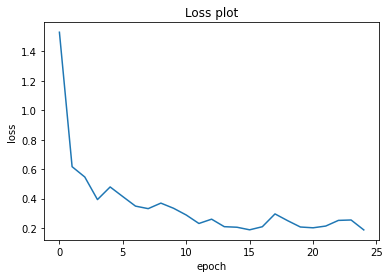

Epoch: 001/025 | Batch 000/1000 | Loss: 9.642551
Epoch: 001/025 | Batch 050/1000 | Loss: 71.033371
Epoch: 001/025 | Batch 100/1000 | Loss: 43.702316
Epoch: 001/025 | Batch 150/1000 | Loss: 19.346245
Epoch: 001/025 | Batch 200/1000 | Loss: 6.426894
Epoch: 001/025 | Batch 250/1000 | Loss: 4.099818
Epoch: 001/025 | Batch 300/1000 | Loss: 3.247373
Epoch: 001/025 | Batch 350/1000 | Loss: 1.503820
Epoch: 001/025 | Batch 400/1000 | Loss: 1.833517
Epoch: 001/025 | Batch 450/1000 | Loss: 2.415946
Epoch: 001/025 | Batch 500/1000 | Loss: 2.336259
Epoch: 001/025 | Batch 550/1000 | Loss: 2.734206
Epoch: 001/025 | Batch 600/1000 | Loss: 1.460362
Epoch: 001/025 | Batch 650/1000 | Loss: 0.794240
Epoch: 001/025 | Batch 700/1000 | Loss: 0.651503
Epoch: 001/025 | Batch 750/1000 | Loss: 0.994176
Epoch: 001/025 | Batch 800/1000 | Loss: 1.381092
Epoch: 001/025 | Batch 850/1000 | Loss: 1.162306
Epoch: 001/025 | Batch 900/1000 | Loss: 0.794628
Epoch: 001/025 | Batch 950/1000 | Loss: 0.849921
Time elapsed: 0.0

Epoch: 009/025 | Batch 350/1000 | Loss: 0.429533
Epoch: 009/025 | Batch 400/1000 | Loss: 0.389284
Epoch: 009/025 | Batch 450/1000 | Loss: 0.354186
Epoch: 009/025 | Batch 500/1000 | Loss: 0.444753
Epoch: 009/025 | Batch 550/1000 | Loss: 0.466408
Epoch: 009/025 | Batch 600/1000 | Loss: 0.260989
Epoch: 009/025 | Batch 650/1000 | Loss: 0.493487
Epoch: 009/025 | Batch 700/1000 | Loss: 0.367949
Epoch: 009/025 | Batch 750/1000 | Loss: 0.326940
Epoch: 009/025 | Batch 800/1000 | Loss: 0.296516
Epoch: 009/025 | Batch 850/1000 | Loss: 0.458119
Epoch: 009/025 | Batch 900/1000 | Loss: 0.314956
Epoch: 009/025 | Batch 950/1000 | Loss: 0.393419
Time elapsed: 0.09 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.346457
Epoch: 010/025 | Batch 050/1000 | Loss: 0.351507
Epoch: 010/025 | Batch 100/1000 | Loss: 0.293844
Epoch: 010/025 | Batch 150/1000 | Loss: 0.422899
Epoch: 010/025 | Batch 200/1000 | Loss: 0.383948
Epoch: 010/025 | Batch 250/1000 | Loss: 0.406905
Epoch: 010/025 | Batch 300/1000 | Loss: 0.3723

Epoch: 017/025 | Batch 850/1000 | Loss: 0.253178
Epoch: 017/025 | Batch 900/1000 | Loss: 0.294848
Epoch: 017/025 | Batch 950/1000 | Loss: 0.218681
Time elapsed: 0.18 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.285772
Epoch: 018/025 | Batch 050/1000 | Loss: 0.215948
Epoch: 018/025 | Batch 100/1000 | Loss: 0.224057
Epoch: 018/025 | Batch 150/1000 | Loss: 0.187517
Epoch: 018/025 | Batch 200/1000 | Loss: 0.247678
Epoch: 018/025 | Batch 250/1000 | Loss: 0.229922
Epoch: 018/025 | Batch 300/1000 | Loss: 0.190920
Epoch: 018/025 | Batch 350/1000 | Loss: 0.274011
Epoch: 018/025 | Batch 400/1000 | Loss: 0.256346
Epoch: 018/025 | Batch 450/1000 | Loss: 0.299323
Epoch: 018/025 | Batch 500/1000 | Loss: 0.315289
Epoch: 018/025 | Batch 550/1000 | Loss: 0.228004
Epoch: 018/025 | Batch 600/1000 | Loss: 0.259425
Epoch: 018/025 | Batch 650/1000 | Loss: 0.265582
Epoch: 018/025 | Batch 700/1000 | Loss: 0.166412
Epoch: 018/025 | Batch 750/1000 | Loss: 0.229223
Epoch: 018/025 | Batch 800/1000 | Loss: 0.2012

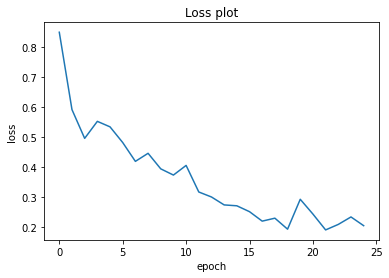

Epoch: 001/025 | Batch 000/1000 | Loss: 10.124384
Epoch: 001/025 | Batch 050/1000 | Loss: 69.294090
Epoch: 001/025 | Batch 100/1000 | Loss: 35.017941
Epoch: 001/025 | Batch 150/1000 | Loss: 9.953599
Epoch: 001/025 | Batch 200/1000 | Loss: 7.834247
Epoch: 001/025 | Batch 250/1000 | Loss: 6.028863
Epoch: 001/025 | Batch 300/1000 | Loss: 5.571725
Epoch: 001/025 | Batch 350/1000 | Loss: 6.160032
Epoch: 001/025 | Batch 400/1000 | Loss: 2.743246
Epoch: 001/025 | Batch 450/1000 | Loss: 3.283714
Epoch: 001/025 | Batch 500/1000 | Loss: 1.523335
Epoch: 001/025 | Batch 550/1000 | Loss: 1.012434
Epoch: 001/025 | Batch 600/1000 | Loss: 1.257962
Epoch: 001/025 | Batch 650/1000 | Loss: 0.999694
Epoch: 001/025 | Batch 700/1000 | Loss: 1.330681
Epoch: 001/025 | Batch 750/1000 | Loss: 2.528968
Epoch: 001/025 | Batch 800/1000 | Loss: 1.751745
Epoch: 001/025 | Batch 850/1000 | Loss: 0.885179
Epoch: 001/025 | Batch 900/1000 | Loss: 0.934700
Epoch: 001/025 | Batch 950/1000 | Loss: 0.904269
Time elapsed: 0.0

Epoch: 009/025 | Batch 250/1000 | Loss: 0.277449
Epoch: 009/025 | Batch 300/1000 | Loss: 0.414241
Epoch: 009/025 | Batch 350/1000 | Loss: 0.445273
Epoch: 009/025 | Batch 400/1000 | Loss: 0.338888
Epoch: 009/025 | Batch 450/1000 | Loss: 0.426918
Epoch: 009/025 | Batch 500/1000 | Loss: 0.365604
Epoch: 009/025 | Batch 550/1000 | Loss: 0.451615
Epoch: 009/025 | Batch 600/1000 | Loss: 0.317620
Epoch: 009/025 | Batch 650/1000 | Loss: 0.324732
Epoch: 009/025 | Batch 700/1000 | Loss: 0.257496
Epoch: 009/025 | Batch 750/1000 | Loss: 0.377915
Epoch: 009/025 | Batch 800/1000 | Loss: 0.341507
Epoch: 009/025 | Batch 850/1000 | Loss: 0.292375
Epoch: 009/025 | Batch 900/1000 | Loss: 0.224519
Epoch: 009/025 | Batch 950/1000 | Loss: 0.415433
Time elapsed: 0.12 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.370328
Epoch: 010/025 | Batch 050/1000 | Loss: 0.356218
Epoch: 010/025 | Batch 100/1000 | Loss: 0.276650
Epoch: 010/025 | Batch 150/1000 | Loss: 0.318113
Epoch: 010/025 | Batch 200/1000 | Loss: 0.3291

Epoch: 017/025 | Batch 450/1000 | Loss: 0.195777
Epoch: 017/025 | Batch 500/1000 | Loss: 0.330959
Epoch: 017/025 | Batch 550/1000 | Loss: 0.291106
Epoch: 017/025 | Batch 600/1000 | Loss: 0.203217
Epoch: 017/025 | Batch 650/1000 | Loss: 0.353102
Epoch: 017/025 | Batch 700/1000 | Loss: 0.120794
Epoch: 017/025 | Batch 750/1000 | Loss: 0.238423
Epoch: 017/025 | Batch 800/1000 | Loss: 0.243101
Epoch: 017/025 | Batch 850/1000 | Loss: 0.183908
Epoch: 017/025 | Batch 900/1000 | Loss: 0.190201
Epoch: 017/025 | Batch 950/1000 | Loss: 0.243148
Time elapsed: 0.23 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.167862
Epoch: 018/025 | Batch 050/1000 | Loss: 0.106204
Epoch: 018/025 | Batch 100/1000 | Loss: 0.214709
Epoch: 018/025 | Batch 150/1000 | Loss: 0.245150
Epoch: 018/025 | Batch 200/1000 | Loss: 0.192036
Epoch: 018/025 | Batch 250/1000 | Loss: 0.156204
Epoch: 018/025 | Batch 300/1000 | Loss: 0.258825
Epoch: 018/025 | Batch 350/1000 | Loss: 0.217440
Epoch: 018/025 | Batch 400/1000 | Loss: 0.1620

Epoch: 025/025 | Batch 800/1000 | Loss: 0.271279
Epoch: 025/025 | Batch 850/1000 | Loss: 0.211470
Epoch: 025/025 | Batch 900/1000 | Loss: 0.164484
Epoch: 025/025 | Batch 950/1000 | Loss: 0.239106
Time elapsed: 0.33 min
Total Training Time: 0.33 min


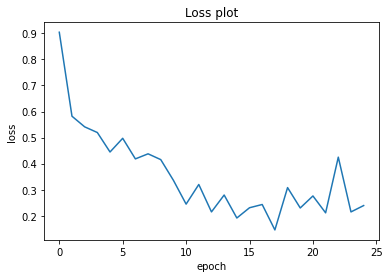

In [22]:
# calculate the standard deviation:
train_errors=[]
test_errors=[]
for num in range(10):
    N_PAIRS = 1000
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)
    my_model = CNN_Net_weight_sharing()
    # train the model
    my_model.trainer(train_input, train_target)
    train_errors.append(my_model.compute_error(train_input, train_target))
    test_errors.append(my_model.compute_error(test_input, test_target))

In [30]:
print('The standard deviation of train error:',np.std(np.divide(train_errors, 100)))
print('The standard deviation of test error:',np.std(np.divide(test_errors, 100)))
print('The mean of train error: %.1f%%'%np.mean(train_errors))
print('The mean of test error: %.1f%%'%np.mean(test_errors))

The standard deviation of train error: 0.01621141573089778
The standard deviation of test error: 0.015666524822052906
The mean of train error: 1.8%
The mean of test error: 17.8%
